# Machine Learning Project

## Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import pathlib
import PIL
import os
import time

from datetime import datetime
from packaging import version

import matplotlib.pyplot as plt
import matplotlib
#set fonts to display labels correctly
matplotlib.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'MS Gothic'
    }
)


## Check GPUs

In [2]:
print("GPUs Available: ", tf.test.gpu_device_name())

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.keras.mixed_precision.set_global_policy("mixed_float16")

GPUs Available:  /device:GPU:0
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


In [3]:
tf.config.threading.set_inter_op_parallelism_threads(64)
tf.config.threading.set_intra_op_parallelism_threads(64)

print(tf.config.threading.get_inter_op_parallelism_threads())
print(tf.config.threading.get_intra_op_parallelism_threads())

64
64


## Load Data

Data stored as 201 images per character, each character's images are grouped in folders labelled with the character.

610236


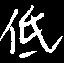

In [4]:

data_dir = pathlib.Path('Data/characters/')

image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

low = list(data_dir.glob('低/*'))
PIL.Image.open(str(low[0]))

## Creating the data pipeline

first parameters for loading

In [5]:
batch_size = 64
img_height = 63
img_width = 64

Split the data into 80% training and 20% testing

In [6]:
seed = 1234

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode='grayscale',
  shuffle=True)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode='grayscale',
  shuffle=True)


class_names = train_ds.class_names
#print(class_names)

#Normalize the data

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

Found 610236 files belonging to 3036 classes.
Using 488189 files for training.
Found 610236 files belonging to 3036 classes.
Using 122047 files for validation.


Print out some of the images to test everything is working

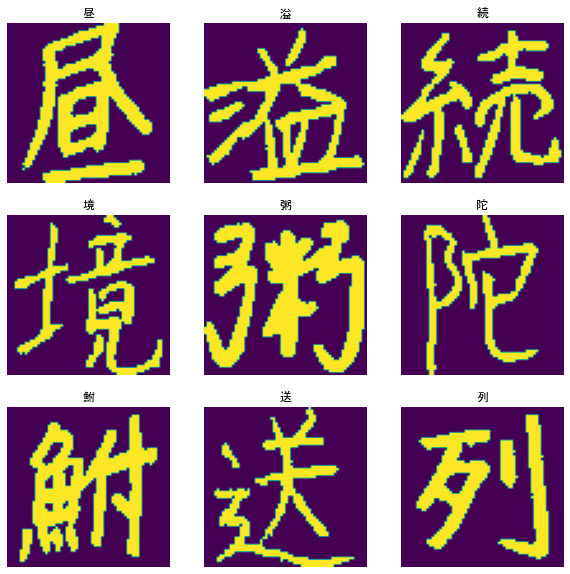

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in normalized_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


# Train the model

## Configure dataset
todo remove .cache()

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_for_performance(ds):
  ds = ds.cache()
  #ds = ds.shuffle(buffer_size=batch_size)
  #ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(normalized_ds)
val_ds = configure_for_performance(val_ds)


## Set up model

structures from [2]

In [9]:
from models import *

model = get_M9(len(class_names))


model.summary()

Model: "M9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2D_1_1_input (Conv2D)    (None, 61, 62, 64)        640       
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 30, 31, 64)        0         
_________________________________________________________________
conv2D_2_1 (Conv2D)          (None, 28, 29, 128)       73856     
_________________________________________________________________
dropout (Dropout)            (None, 28, 29, 128)       0         
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 14, 14, 128)       0         
_________________________________________________________________
conv2D_3_1 (Conv2D)          (None, 12, 12, 256)       295168    
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 256)       0        

In [10]:
model_dir = './models/'

filepath = os.path.join(model_dir, "tf", "checkpoints", "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

log_dir = os.path.join(model_dir, "tf", "logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [checkpoint, tensorboard_callback]

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001,
                                beta_1=0.9,
                                beta_2=0.999,
                                epsilon=1e-08,)
#learning_rate=0.0001

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    x=train_ds,
    epochs=20,
    initial_epoch=0,
    validation_data=val_ds,
    callbacks=callbacks_list,
    max_queue_size=400,
    use_multiprocessing=True,
    workers=2)

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

#print(test_acc)

## References

[1] Electrotechnical Laboratory, “ETL-9 Character Database.” Japanese Technical Committee for Optical Character Recognition, 1984.

[2] CaptainDario, “DaKanjiRecognizer-ML,” 2021. https://github.com/CaptainDario/DaKanjiRecognizer-ML.

[3] Charlie Tsai, “Recognizing Handwritten Japanese Characters Using Deep Convolutional Neural Networks,” pp. 1–7, 2016.
